# Assignment2 Classify Images of Road Traffic Signs
Load necessary packages

In [1]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

Using TensorFlow backend.


load data and categorized

In [2]:
def load_img_data():
    image_list = []
    #transfer file name to target name
    for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive = True):
        filename = filepath.split("/")[-1]
        sign_shape = filepath.split("/")[1]
        sign_type = filepath.split("/")[2]
        image_list.append((filepath, sign_shape, sign_type))
        
    data = pd.DataFrame(data=image_list, columns=['image_path','sign_shape', 'sign_type'])
    
    # Convert string labels to numeric
    shapes = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}
    types = {'rightofway':0, 'stop':1, 'bicycle':2, 'limitedtraffic':3, 'noentry':4, 'noparking':5, 'roundabout':6, 'speed':7, 
             'trafficdirective':8, 'traveldirection':9, 'continue':10, 'crossing':11, 'laneend':12, 'parking':13, 'giveway':14, 'warning':15}
    data['shape_numeric'] = data['sign_shape'].map(shapes, na_action='ignore')
    data['type_numeric'] = data['sign_shape'].map(types, na_action='ignore')
    return data

split data into training, validating data. not spliting into validating data is because we will be using other images for testing

In [3]:
trainData, validationData = train_test_split(load_img_data(), test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2
print('Train size: {}, Test size: {}'.format(trainData.shape[0], validationData.shape[0] ) )
train_size = trainData.shape[0]
validation_size = validationData.shape[0]

Train size: 2954, Test size: 739


# Below are serveral of function defined for training
create and config a deep learning model cnn. varioius configuration will be tuned to get the best model in a single function

In [4]:
def data_generator(trainData, testData, target):
    train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    batch_size = 16

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=trainData,
            directory='./',
            x_col="image_path",
            y_col=target,
            target_size=(28, 28),
            batch_size=batch_size,
            class_mode='categorical')

    validation_generator = val_datagen.flow_from_dataframe(
            dataframe=testData,
            directory='./',
            x_col="image_path",
            y_col=target,
            target_size=(28, 28),
            batch_size=batch_size,
            class_mode='categorical')
    return train_generator, validation_generator

In [5]:
def create_model_for_shapes():
    model_cnn = Sequential()

    # input
    model_cnn.add(Input(shape=(28, 28, 3)))
    # change back to 1 channel
    model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    # Layer 1 with 32 depth, 3x3 kernel, weight 0.01
    model_cnn.add(Conv2D(16, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # MLP
    model_cnn.add(Flatten())  # this converts feature maps to 1D feature vectors
    model_cnn.add(Dense(64))
    model_cnn.add(Activation('relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(5))
    model_cnn.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[categorical_accuracy])

    return model_cnn

In [6]:
def create_model_for_types():
    model_cnn = Sequential()

    # input
    model_cnn.add(Input(shape=(28, 28, 3)))
    # change back to 1 channel
    model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    # Layer 1 with 32 depth, 3x3 kernel, weight 0.001
    model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 1 with 32 depth, 3x3 kernel, weight 0.001
    model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
    model_cnn.add(Activation('relu'))
    model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # MLP
    model_cnn.add(Flatten())  # this converts feature maps to 1D feature vectors
    model_cnn.add(Dense(64))
    model_cnn.add(Activation('relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(16))
    model_cnn.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model_cnn.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=[categorical_accuracy])

    return model_cnn

train the model and validate

In [7]:
def train_model(model_, train_generator_in, validation_generator_in, num_epoch=50, verbose=False):
    batch_size = 16
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator_in:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= train_size / batch_size:
                # break when needed
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator_in, validation_size, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

evaluate the model by validating data.

In [8]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # break when needed
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

draw the graph and print numerical accuracy for evaluation

In [9]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])
    print("Losses: ", res[:,3]);
    plt.savefig('losses.png')

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])
    
    print("Accuracy: ", res[:,4]);
    plt.savefig('accuracy.png')

generate traning and validating data to fit the model, after final tunning, 20 epoch is the best fit for shape and 80 is for types.

Found 2954 validated image filenames belonging to 5 classes.
Found 739 validated image filenames belonging to 5 classes.
Losses:  [0.2976929  0.17470751 0.12043921 0.08577862 0.08768137 0.06544432
 0.06114547 0.05581132 0.05627791 0.04755713 0.05840794 0.05065907
 0.05627617 0.05796649 0.04608005 0.04817849 0.05125579 0.05835882
 0.05009597 0.03977084]
Accuracy:  [0.91888298 0.93838653 0.96409574 0.9787234  0.97562057 0.98537234
 0.98404255 0.99069149 0.99069149 0.99069149 0.98537234 0.9893617
 0.9893617  0.9893617  0.99202128 0.9893617  0.9893617  0.9893617
 0.98803191 0.99335106]


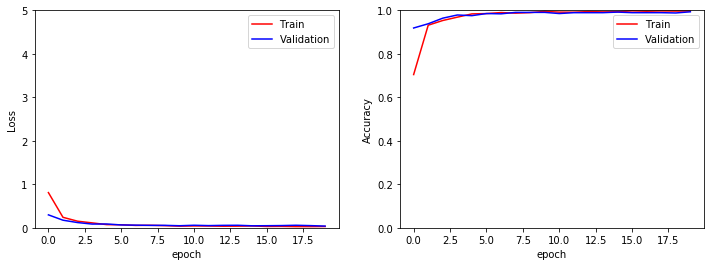

In [12]:
model_shapes = create_model_for_shapes()
train_generator, validation_generator = data_generator(trainData, validationData, "sign_shape")
res = train_model(model_shapes, train_generator, validation_generator, num_epoch=20, verbose=False)
plot_results(res)

Found 2954 validated image filenames belonging to 16 classes.
Found 739 validated image filenames belonging to 16 classes.
Losses:  [0.90024166 0.48867584 0.30261014 0.28353013 0.20237501 0.22984289
 0.17279011 0.18073957 0.14900324 0.15961249 0.14301362 0.13731053
 0.12487696 0.11921949 0.11487006 0.13748282 0.11249302 0.11880579
 0.10821783 0.11099001 0.09798972 0.09651324 0.11019762 0.09239231
 0.08519075 0.08969538 0.08972446 0.08371128 0.08171764 0.09471806
 0.08377275 0.08679118 0.08143223 0.09053715 0.08260262 0.08441431
 0.07267472 0.08552206 0.08124174 0.07097961 0.07995143 0.06953541
 0.07898438 0.07519921 0.06941887 0.09612852 0.07130628 0.06882079
 0.06506572 0.06959775 0.06290109 0.05901177 0.07037936 0.06647156
 0.0665713  0.06431651 0.06168068 0.06304356 0.06947017 0.06600884
 0.06709835 0.06924921 0.06650623 0.05943935 0.06261491 0.05563643
 0.0622385  0.0628232  0.06122307 0.0593161  0.06488649 0.06242142
 0.059775   0.06076068 0.06270864 0.06199188 0.06734954 0.059948

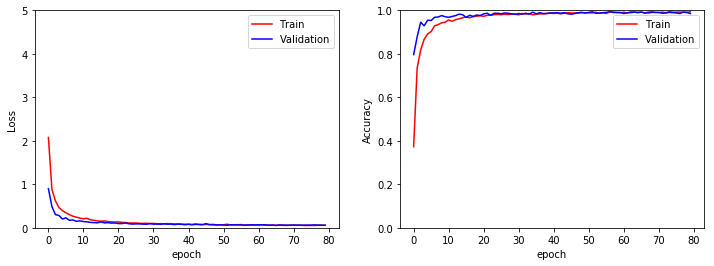

In [13]:
model_types = create_model_for_types()
train_generator, validation_generator = data_generator(trainData, validationData, "sign_type")
res = train_model(model_types, train_generator, validation_generator, num_epoch=80, verbose=False)
plot_results(res)

# for the actual model and testing test data.

In [14]:
def load_image(img_path):

    img = image.load_img(img_path, target_size=(28, 28))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return img_tensor

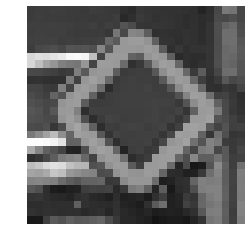

In [63]:
img = load_image("./testing_data/00032_00002.png");

In [59]:
shapes = {'diamond', 'hex', 'round', 'square', 'triangle'}
types = {'rightofway', 'stop', 'bicycle', 'limitedtraffic', 'noentry', 'noparking', 'roundabout', 'speed', 
             'trafficdirective', 'traveldirection', 'continue', 'crossing', 'laneen', 'parking', 'giveway', 'warning'}
shapes = sorted(shapes)
types = sorted(types)

In [60]:
pred = model_shapes.predict_classes(img, verbose=0)
print(shapes[pred[0]])

diamond


In [61]:
pred = model_types.predict_classes(img, verbose=0)
print(types[pred[0]])

rightofway
